# Formation ML Flow

L'objectif de cette formation est de vous apprendre à utiliser ML Flow   
MLflow est un dashboard pour expériences de Machine Learning.  
Ce tp permet pas à pas comment lancer une expérience de Machine Learning et surveiller les paramètres, métriques et resultats de votre expérience grâce à ML Flow.

Nous allons mettre en place plkusieurs modèles et découvrir MLflow

### import des librairies

In [1]:
import mlflow, math, time
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# 1. Ouverture et visualisation du dataset Iris

In [2]:
# permet d'avoir accès au dataset une fois qu'il sera chargé
dataset_columns = ['sepal length', 'sepal width', 'petal length', 'petal width']

try: 
    dataset = pd.read_csv('iris.csv')
except FileNotFoundError:
    iris_data = datasets.load_iris(as_frame=True)
    dataset = iris_data.get('data')
    dataset.columns = columns=dataset_columns
    dataset["target"] = iris_data.get('target')
    dataset['target'] = dataset['target'].replace(dataset['target'].unique().tolist(), iris_data.get('target_names'))
    dataset.to_csv('iris.csv', index=False)
dataset.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# affichons en une simple ligne de code les caractéristiques des colonnes numériques

#Code ici
dataset.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
# Verifions que les données soient bien homogènes (2 méthodes)

# Code ici


Affichons maintenant le nuage de points de chaque paire de caractéristiques. Sur la diagonale, on retrouve un histogramme du nombre d'échantillons selon la valeur de la caractéristique. On peut remarquer certaines structures, par exemple des groupes, dans les relations entre certaines caractéristiques.

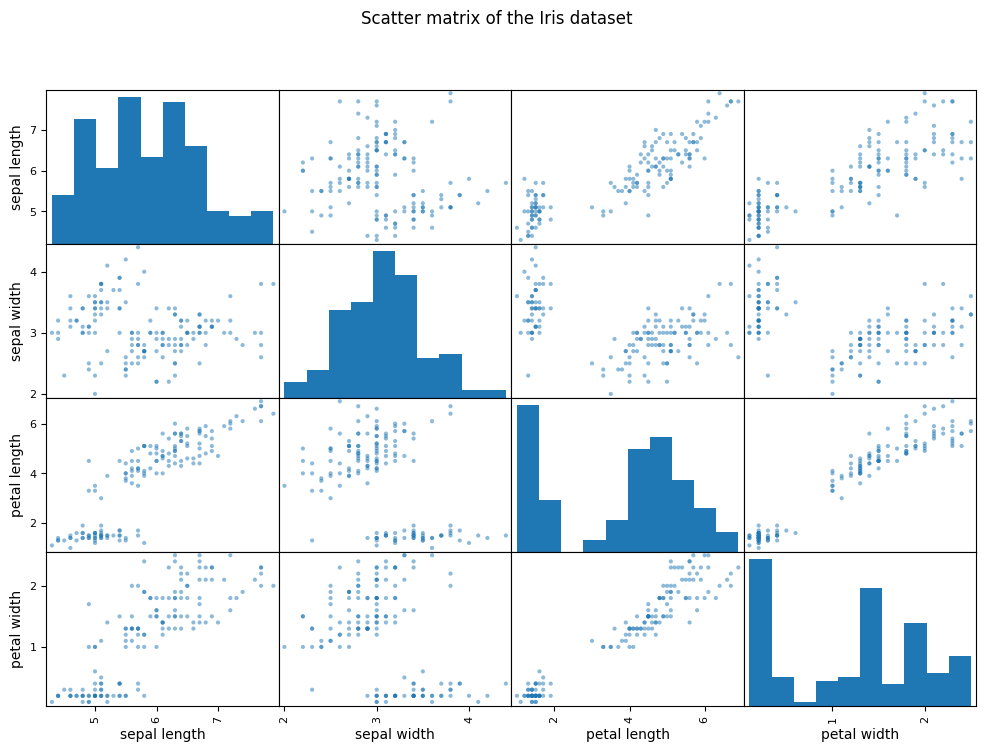

In [4]:
# tout groupe confondu, affichez le nuage de point par paire de variable et en diagonale l'histogramme de la variable 
pd.plotting.scatter_matrix(dataset,figsize=(12,8))
plt.suptitle('Scatter matrix of the Iris dataset')
plt.show()

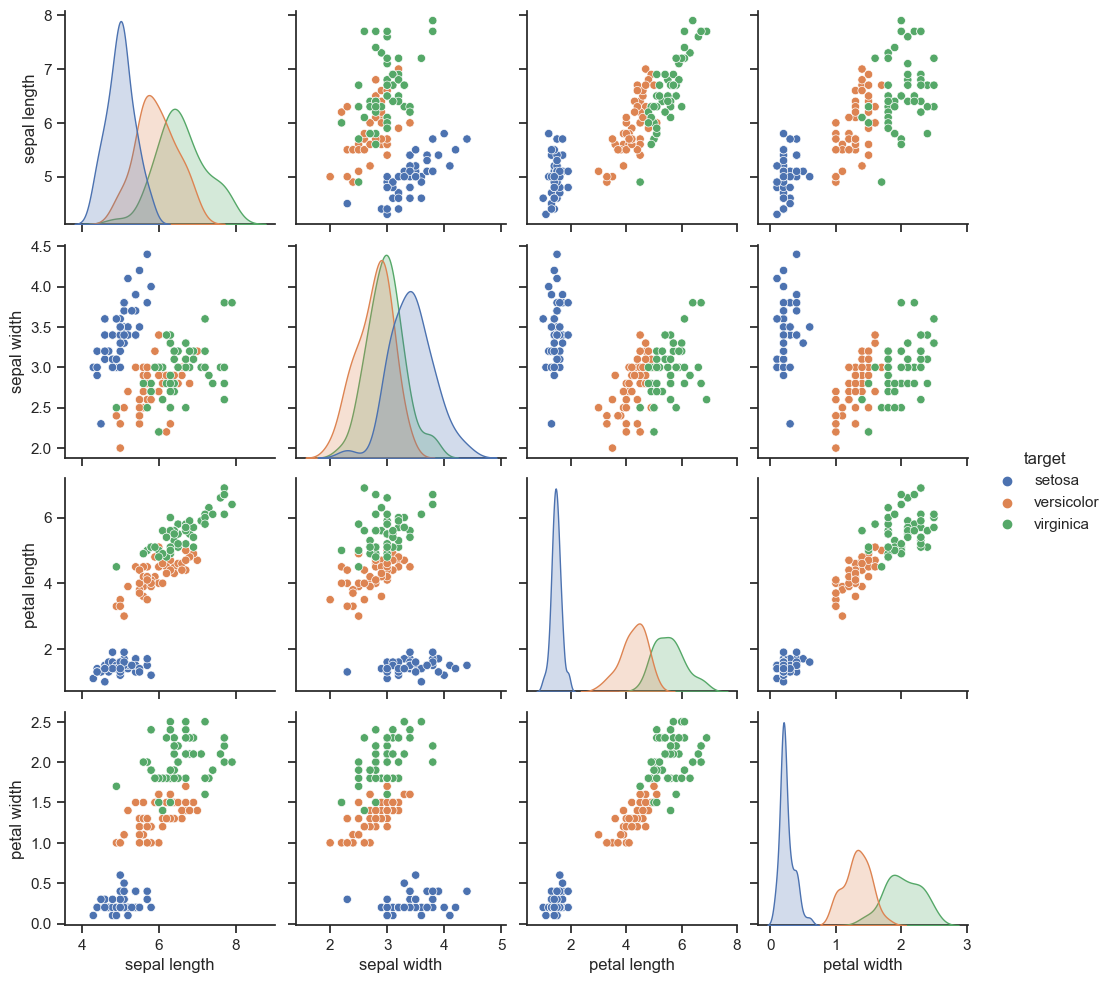

In [5]:
#essayons avec seaborn, et mettons une couleur par classe

#Code ici
sns.set_theme(style="ticks")

sns.pairplot(dataset, hue = "target")

On remarque des corrélations avec certaines caractéristiques

# 2. ML Flow : premiers pas avec un modèle aléatoire

Pour un premier exemple prenons une classification 'simple' : le modèle aléatoire. Ce modèle attribuera aléatoirement une classe à chaque échantillon du dataset. 

Séparons le dataset en deux X, nos features et Y notre class des iris


In [6]:
X = dataset.loc[:,dataset_columns].values
Y = dataset.target.values

In [7]:
#Construisons notre modèle aléatoire :
dummy = DummyClassifier(strategy="uniform")
dummy.fit(X, Y)

DummyClassifier(strategy='uniform')

Affichons ses prédictions pour les premiers échantillons :

In [8]:
Y_pred = dummy.predict(X)
for i in range(5):
    print(X[i], ', vraie classe : ', Y[i], ', prédiction : ', Y_pred[i])

[5.1 3.5 1.4 0.2] , vraie classe :  setosa , prédiction :  virginica
[4.9 3.  1.4 0.2] , vraie classe :  setosa , prédiction :  virginica
[4.7 3.2 1.3 0.2] , vraie classe :  setosa , prédiction :  versicolor
[4.6 3.1 1.5 0.2] , vraie classe :  setosa , prédiction :  versicolor
[5.  3.6 1.4 0.2] , vraie classe :  setosa , prédiction :  versicolor


Je vous laisse imagienr la qualité du modèle sachant qu'il prédit ce qu'il apprend ...

C'est maintenant que MLflow rentre en jeu, enregistrons les performances du modèle  
Histoire de ne pas avoir d'erreur créons un fichier `iris.txt`

In [9]:
!echo > iris.txt

In [10]:
with mlflow.start_run(run_name='Modele_Aleatoire'):
    mlflow.log_param('Je teste mon modèle', 'DummyClassifier')
    mlflow.log_metric('Accuracy', accuracy_score(Y, Y_pred))
    mlflow.log_artifact('iris.txt')

In [11]:
with mlflow.start_run(run_name='Modele_Aleatoire avec csv'):
    mlflow.log_param('Je teste mon modèle', 'DummyClassifier')
    mlflow.log_metric('Accuracy', accuracy_score(Y, Y_pred))
    mlflow.log_artifact('iris.csv')

ici on a remplacé le fichier vide `iris.txt` par `iris.csv`

Si jamais vous avez supprimé votre dossier `mlruns` relancez le notebook

PAUSE ! c'est là ou ça devient intéressant, vous venez de créer un nouveau dossier `mlruns`, il est nécessaire pour la suite des évènements



Toujours dans le dossier formation-mlflow, entrez la commande mlflow ui. Le message Serving on http://XXXXXXX:5000 devrait s'afficher. Ouvrez maintenant un navigateur web et ouvrez une fenêtre vers l'url http://localhost:5000/

In [12]:
!mlflow ui

^C


Ca y est les resultats sont visibles sur l'interface ! discutons en un peu

ML Flow permet d'enregistrer puis visualiser 4 types de choses :

des paramètres : ce sont des valeurs (int, float, string, ...) qui ne varient pas au cours d'un 'run', ici `MODEL_NAME` ou encore `je teste mon modèle` est un paramètre   

des métriques : ce sont des valeurs numériques qui peuvent varier au cours du 'run', ici Accuracy est une métrique   

des fichiers : ces fichiers peuvent prendre n'importe quelle forme (png, jpeg, gif, txt, ...) et ne sont pas modifiables au cours du 'run. Ici nous avons fait une copie du fichier iris.csv et de iris.txt   

Toutes ces variables sont regroupées dans un même 'run', ici nommé `Modele_Aleatoire` ou `modele aleatoire avec csv`. Un 'run' correspond à une ligne du tableau. Les 'runs' peuvent être regroupés en 'experiences', ici nommée Default dans la colonne de gauche. Nous verons comment changer le nom de l'expérience par la suite  

In [13]:
# 1. Création du 'run' ML FLow, nommé ici 'Modele_Aleatoire'
#    un run est inclus dans une expérience
with mlflow.start_run(run_name='Modele_Aleatoire'):

    # 2. Enregistrement d'un paramètre, c'est par exemple le nom de notre modèle testé, les fameux 'final1', 'final_final'
    mlflow.log_param('MODEL_NAME', 'DummyClassifier')

    # 3. Enregistrement d'une métrique, pour qu'on n'ait plus besoin de l'ecrire sur un cahier ou sur excel
    mlflow.log_metric('Accuracy', accuracy_score(Y, Y_pred))

    # 4. Enregistrement d'un fichier, c'est notre artefact, ce qui permet aussi le reproductibilité
    mlflow.log_artifact('iris.csv')

## Exercice d'application  

petal width est une variable très discriminante pour classifier

<AxesSubplot: xlabel='petal width', ylabel='target'>

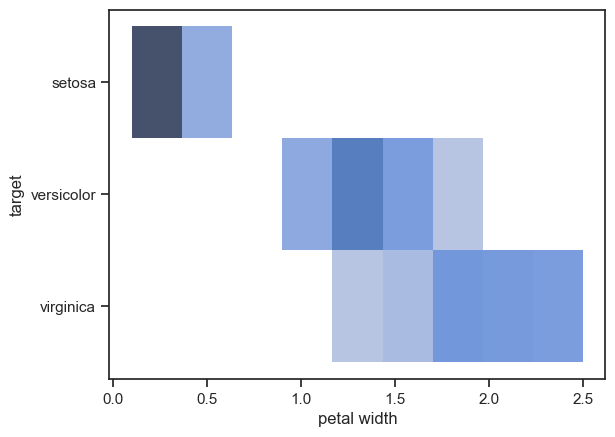

In [14]:
sns.histplot(dataset, x='petal width', y='target')

Nous allons donc essayer de coder notre propre modèle de classification selon cette spécificité et enregistrer ses performances avec ML FLow.

Pour cela, commencez par coder une fonction qui :

prend en entrée une liste d'échantillons  
retourne la liste des classes des échantillons  
afin de retourner la classe de façon automatisée crée un quantile à 0.33 et un à 0.66, les classes seront dans l'ordre suivant :  
- setosa, versicolor, virginica 

In [15]:
def simple_classification_model(list_samples):
    """
    list_sample represente l'ensemble des feature
    quantile est une liste comme celle ci : [elem1, elem2] 
    """
    #Code ici
    petal_width_class = []
    q33 = np.quantile(list_samples, 0.33, axis = 0)[3]
    q66 = np.quantile(list_samples, 0.66, axis = 0)[3]
    for i in list_samples:
        if i[3] < q33:
            petal_width_class.append("setosa")
        elif i[3] < q66:
            petal_width_class.append("versicolor")
        else:
            petal_width_class.append("virginica")
    return petal_width_class


Vérifions ici que notre modele fonctionne sur quelques échantillons :

In [16]:
Y_pred_cond = simple_classification_model(X)
for i in range(5):
    print(X[i], ', vraie classe : ', Y[i], ', prédiction : ', Y_pred_cond[i])

[5.1 3.5 1.4 0.2] , vraie classe :  setosa , prédiction :  setosa
[4.9 3.  1.4 0.2] , vraie classe :  setosa , prédiction :  setosa
[4.7 3.2 1.3 0.2] , vraie classe :  setosa , prédiction :  setosa
[4.6 3.1 1.5 0.2] , vraie classe :  setosa , prédiction :  setosa
[5.  3.6 1.4 0.2] , vraie classe :  setosa , prédiction :  setosa


utilisons à nouveau MLflow

In [17]:
#Code ici
!mlflow ui

^C


# 3. ML Flow : Comparaison de plusieurs modèles

C'est là ou MLflow devient très intéressant ! il permet de centraliser les experiences afin d'améliorer les comparaisons.  
nous allons créer plusieurs modèles très simples, pour se faire séparons notre dataset 

In [18]:
random_seed = 1
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=random_seed)

Construisons la liste des modèles à tester :

In [19]:
models = []
models.append(('LogisticRegression', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

Ajoutons cette fonction qui va nous permettre de tracer de jolies matrices de confusion par la suite :

In [20]:
def plot_confusion_matrix(cm, target_names, title, 
                          normalize=True, save_path='matrix.png'):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'\
               .format(accuracy, misclass))
    plt.gcf().canvas.draw()
    plt.savefig(save_path)
    plt.close()

Nous allons maintenant entraîner nos modèles et enregistrer leurs paramètres et métriques avec ML Flow.

Nous allons voir deux nouvelles choses :

Comment créer une nouvelle expérience
Comment enregistrer plusieurs paramètres ou métriques d'un seul coup

In [21]:
# avant cela nous allons reconstruire le dataset pour savoir le train et le test
def artifact_df(X_training, Y_training, X_valid, Y_valid):
    df_train = pd.DataFrame(X_training, columns=dataset_columns)
    df_train['target'] = Y_training
    df_train.to_csv('train_data.csv')

    df_val = pd.DataFrame(X_valid, columns=dataset_columns)
    df_val['target'] = Y_valid
    df_val.to_csv('validation_data.csv')

    return None

In [22]:
# 1. Création d'une nouvelle expérience
#    Tous les nouveaux runs seront enregistrés dans cette expérience
mlflow.set_experiment('Compare_models')

for name, model in models:
    print(name)

    # 2. Création et début d'un nouveau run
    with mlflow.start_run(run_name=name):

        # 3. Enregistrement de plusieurs paramètres sous forme d'un dictionnaire
        params = {}
        params['MODEL_NAME'] = name
        params['TRAIN_SIZE'] = len(X_train)
        params['TEST_SIZE'] = len(X_val)
        params['SEED'] = random_seed
        mlflow.log_params(params)

        # On note le moment du début de l'expérience pour mesurer la durée de l'entraînement
        start = time.time()

        # Entraînement du modèle
        model.fit(X_train, Y_train)

        training_time = time.time() - start

        predictions = model.predict(X_val)

        # 4. Enregistrement de plusieurs métriques sous forme d'un dictionnaire
        metrics = {}
        metrics['Accuracy'] = accuracy_score(Y_val, predictions)
        metrics['Precision'] = precision_score(Y_val, predictions, average='macro')
        metrics['Recall'] = recall_score(Y_val, predictions, average='macro')
        metrics['Training Time'] = training_time
        mlflow.log_metrics(metrics)

        # 5. Enregistrement de la matrice de confusion
        cm = confusion_matrix(Y_val, predictions)
        plot_confusion_matrix(cm, ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
                              'Confusion matrix '+name)
        mlflow.log_artifact('matrix.png')
        artifact_df(X_train, Y_train, X_val, Y_val)
        mlflow.log_artifact('train_data.csv')
        mlflow.log_artifact('validation_data.csv')

LogisticRegression
LinearDiscriminantAnalysis
KNeighborsClassifier
DecisionTreeClassifier
GaussianNB
SVM


Dans la partie gauche de l'UI vous trouverez 2 experiences differentes, selectionnez `Compare_models` et pour chaque run vous aurez la matrice de confusion et le train, test associé

# Exercice d'application

utilisez la fonction qui classifie de façon conditionnelle les iris dans l'experience crée juste avant  

In [ ]:
mlflow.set_experiment('Compare_models')

with mlflow.start_run(run_name='My_Conditional_Model'):

    #Code ici

# 4. ML Flow : Enregistrer l'évolution d'une métrique

Dans cette dernière partie, nous allons voir comment enregistrer l'évolution d'une métrique au cours du temps. Pour cela, nous allons utiliser comme modèle un réseau de neurones basique : le perceptron multi-couches.

Afin de calculer nos métriques au cours de l'entrainement, nous decoupons celui-ci en plusieurs epochs. A chaque epoch, le reseau de neurone s'entraîne une fois sur l'intégralité du dataset. Tout ceci est fait automatiquement dans la fonction fit par défaut de scikit learn, mais nous allons faire les choses manuellement ici, pour visualiser l'évolution des métriques au cours de l'apprentissage.

In [23]:
# 1. Création et début d'un nouveau run
with mlflow.start_run(run_name='Multilayer Perceptron'):

    model = MLPClassifier(max_iter=10)
    mlflow.log_param('MODEL_NAME', 'MLPClassifier')

    N_TRAIN_SAMPLES = X_train.shape[0]
    N_EPOCHS = 10
    N_BATCH = 8
    N_CLASSES = np.unique(Y_train)
    scores_train = []
    scores_test = []

    # EPOCH
    epoch = 0
    while epoch < N_EPOCHS:
        if epoch % 2 == 0 : print('Epoch: ', epoch)
        # SHUFFLING
        random_perm = np.random.permutation(X_train.shape[0])
        mini_batch_index = 0
        while True:
            # TRAIN ON MINI-BATCH
            indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
            model.partial_fit(X_train[indices], Y_train[indices], classes=N_CLASSES)
            mini_batch_index += N_BATCH
            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

        metrics = {}
        predictions = model.predict(X_val)
        metrics['Accuracy'] = accuracy_score(Y_val, predictions)
        metrics['Precision'] = precision_score(Y_val, predictions, average='macro')
        metrics['Recall'] = recall_score(Y_val, predictions, average='macro')
        metrics['Loss'] = model.loss_
        # 2. Enregistrement de plusieurs métriques pour une epoch donnée
        mlflow.log_metrics(metrics, step=epoch)
        time.sleep(3)

        epoch += 1

Epoch:  0


C:\Users\utilisateur\anaconda3\envs\brief-mlops\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\utilisateur\anaconda3\envs\brief-mlops\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:  2


C:\Users\utilisateur\anaconda3\envs\brief-mlops\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:  4
Epoch:  6
Epoch:  8


Revenez sur le tableau des runs dans le dashboard et ouvrez le run que nous venons de créer. En cliquant sur l'une des métriques, vous pourrez voir son évolution au cours de l'apprentissage du réseau de neurones.

# (OPTIONAL
) 5. Un exercice d'application des temps d'attente


Pour finir, je vous propose un exercice d'application sur le thème d'un parc d'attraction, qui regroupera tout ce que nous avons appris ici.

Pour cela nous allons étudier les temps d'attente de 3 attractions sur 10 jours d'avril  
FYI : les données on été choquées avec une uniforme pour qu'elles ne représentent pas totalement la réalité

In [ ]:
wait_df = pd.read_csv('wait.csv')
wait_df = wait_df.sort_values("start").reset_index()
# on enleve les 10 derniers elements de chaque groupe
result1 = wait_df.drop(wait_df.groupby('attraction').tail(10).index, axis=0)

In [ ]:
df = wait_df.drop_duplicates()
plt.figure(figsize=(8,6))
plt.plot(df.start, df.waiting_time)
plt.title("temps d'attente sur une attraction en avril 2022")
plt.ylabel('temps (min)')
plt.xticks(df.start.values[::300], rotation=45)
plt.show()

Créez au moins 3 modèles de prévisions des temps d'attente pour `l'attraction_2` uniquement et sur les 30 dernières periodes du dataframe disponible
Ajoutez au moins 3 métriques pour évaluer les performances de vos modèles  
Pour chaque métrique, évaluez là sur l'ensemble de votre prévision, mais aussi sur chacune des échéances (T1, ..., Tk) afin de tracer dans MLFlow la courbe d'évolution de cette métrique.  
Enregistrez tout cela dans MLFlow, dans une nouvelle expérience.  
conseil : persistence, lag et forecast 

In [ ]:
# AJOUTEZ VOTRE CODE ICI